In [ ]:
import os
import glob
import copy

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

import getdist
import getdist.plots
import numpy as np
import scipy.stats

pi = np.pi

In [1]:
import sys
sys.path.append("../../KiDS/kcap/utils/")

import process_chains
import stat_tools

import importlib

In [2]:
import getdist.chains
getdist.chains.print_load_details = False

In [11]:
text_width = 523.5307/72
column_width = 256.0748/72

plot_settings = getdist.plots.GetDistPlotSettings()
plot_settings.figure_legend_frame = False
plot_settings.legend_frame = False
plot_settings.figure_legend_loc = "upper right"
plot_settings.alpha_filled_add=0.8
plot_settings.alpha_factor_contour_lines=0.8
plot_settings.fontsize = 10
# plot_settings.axes_fontsize = 8
#plot_settings.lab_fontsize = 8
plot_settings.legend_fontsize = 10

plot_settings.x_label_rotation = 45.0

matplotlib.rc("text", usetex=False)
# matplotlib.rc("text.latex", preamble=r"""
# \usepackage{txfonts}
# \newcommand{\mathdefault}[1][]{}""")

matplotlib.rc("font", family="Times")

In [12]:
def get_chain_color(chain):
    return chain.chain_def["color"]

def get_chain_label(chain):
    return chain.chain_def["label"]

def select_chains(chains, selection, global_selection=None):
    selected_chains = [None]*len(selection)
    for c in chains.values():
        for i, selection_criteria in enumerate(selection):
            matches_all_selection_criteria = all([c.chain_def[k] == v for k,v in selection_criteria.items()])
            if matches_all_selection_criteria:
                selected_chains[i] = c
    
    [selected_chains.pop(i) for i, s in enumerate(selected_chains) if s is None]
        
    return selected_chains

In [7]:
base_dir = "../runs/"

chain_def_fiducial = [
            {"root_dir" : os.path.join(base_dir, 
                                        "run0_multinest/"),
              "name"     : "run0",
              "label"    : "KiDS-1000 x tSZ run0",
              "n_varied" : 8,
              "color"    : "C0"}, 
                    ]
chain_def_KiDS_1000 = [
            {"root_dir" : "/home/ttroester/Research/KiDS/kcap/runs/3x2pt/data_iterated_cov/cosmology/multinest_blindC_EE",
             "name"     : "EE",
             "label"    : "Cosmic shear, fiducial",
             "n_varied" : 12,
             "color"    : "C1"},
             {"root_dir" : "/home/ttroester/Research/KiDS/kcap/runs/extended_cosmologies/data/cosmology/multinest_medium_blindC_EE_HMx",
             "name"     : "EE_HMx",
             "label"    : "Cosmic shear, HMx",
             "n_varied" : 12,
             "color"    : "C2"},
                    ]

In [8]:
chains = {}

In [9]:
defs = [
     *chain_def_fiducial,
     *chain_def_KiDS_1000,
      ]

for c in defs:
    print(f"Chain {c['name']}")

    # Load chain
    chain_file = glob.glob(os.path.join(c["root_dir"], "output/samples_*.txt"))\
                    + glob.glob(os.path.join(c["root_dir"], "chain/samples_*.txt"))
    if len(chain_file) != 1:
        raise ValueError(f"Could not find unique chain file in {c['root_dir']}")
    chain_file = chain_file[0]

    value_file = os.path.join(c["root_dir"], "config/values.ini")

    s = process_chains.load_chain(chain_file, values=value_file, run_name=c["name"], 
                                  strict_mapping=False, ignore_inf=True, burn_in=c.get("burn_in", 0.5))

    param_names = [n.name for n in s.getParamNames().names]
                         
    if "omegamh2" not in param_names:
        s.addDerived(s.getParams().omegam*s.getParams().h**2,
                     name="omegamh2", label="\\Omega_{\\rm m} h^2")
    if "omeganuh2" not in param_names and "omeganu" in param_names:
        s.addDerived(s.getParams().omeganu*s.getParams().h**2,
                     name="omeganuh2", label="\\Omega_{\\nu} h^2")
    if "Sigmaalpha" not in [n.name for n in s.getParamNames().names]:
        s.addDerived(s.getParams().sigma8*(s.getParams().omegam/0.3)**0.58,
                     name="Sigmaalpha", label="\\Sigma_{8}")

    s.chain_def = c
    chains[c["name"]] = s

Chain run0
Using 2202 samples out of 2202 in the chain.
Chain EE
Using 17122 samples out of 17122 in the chain.
Chain EE_HMx
../../KiDS/kcap/utils/process_chains.py:638: UserWarning: Parameter cosmological_parameters--sigma_8_lcdm in chain does not have mapping to cosmomc format.
  warnings.warn(f"Parameter {p} in chain does not have mapping to {parameter_map} format.")
../../KiDS/kcap/utils/process_chains.py:638: UserWarning: Parameter cosmological_parameters--s_8_lcdm in chain does not have mapping to cosmomc format.
  warnings.warn(f"Parameter {p} in chain does not have mapping to {parameter_map} format.")
Using 8333 samples out of 8333 in the chain.


Plotting 3 chains (KiDS-1000 x tSZ run0, Cosmic shear, fiducial, Cosmic shear, HMx)
Plotting parameters omegam sigma8 s8 a_ia logt_heat alpha_cib


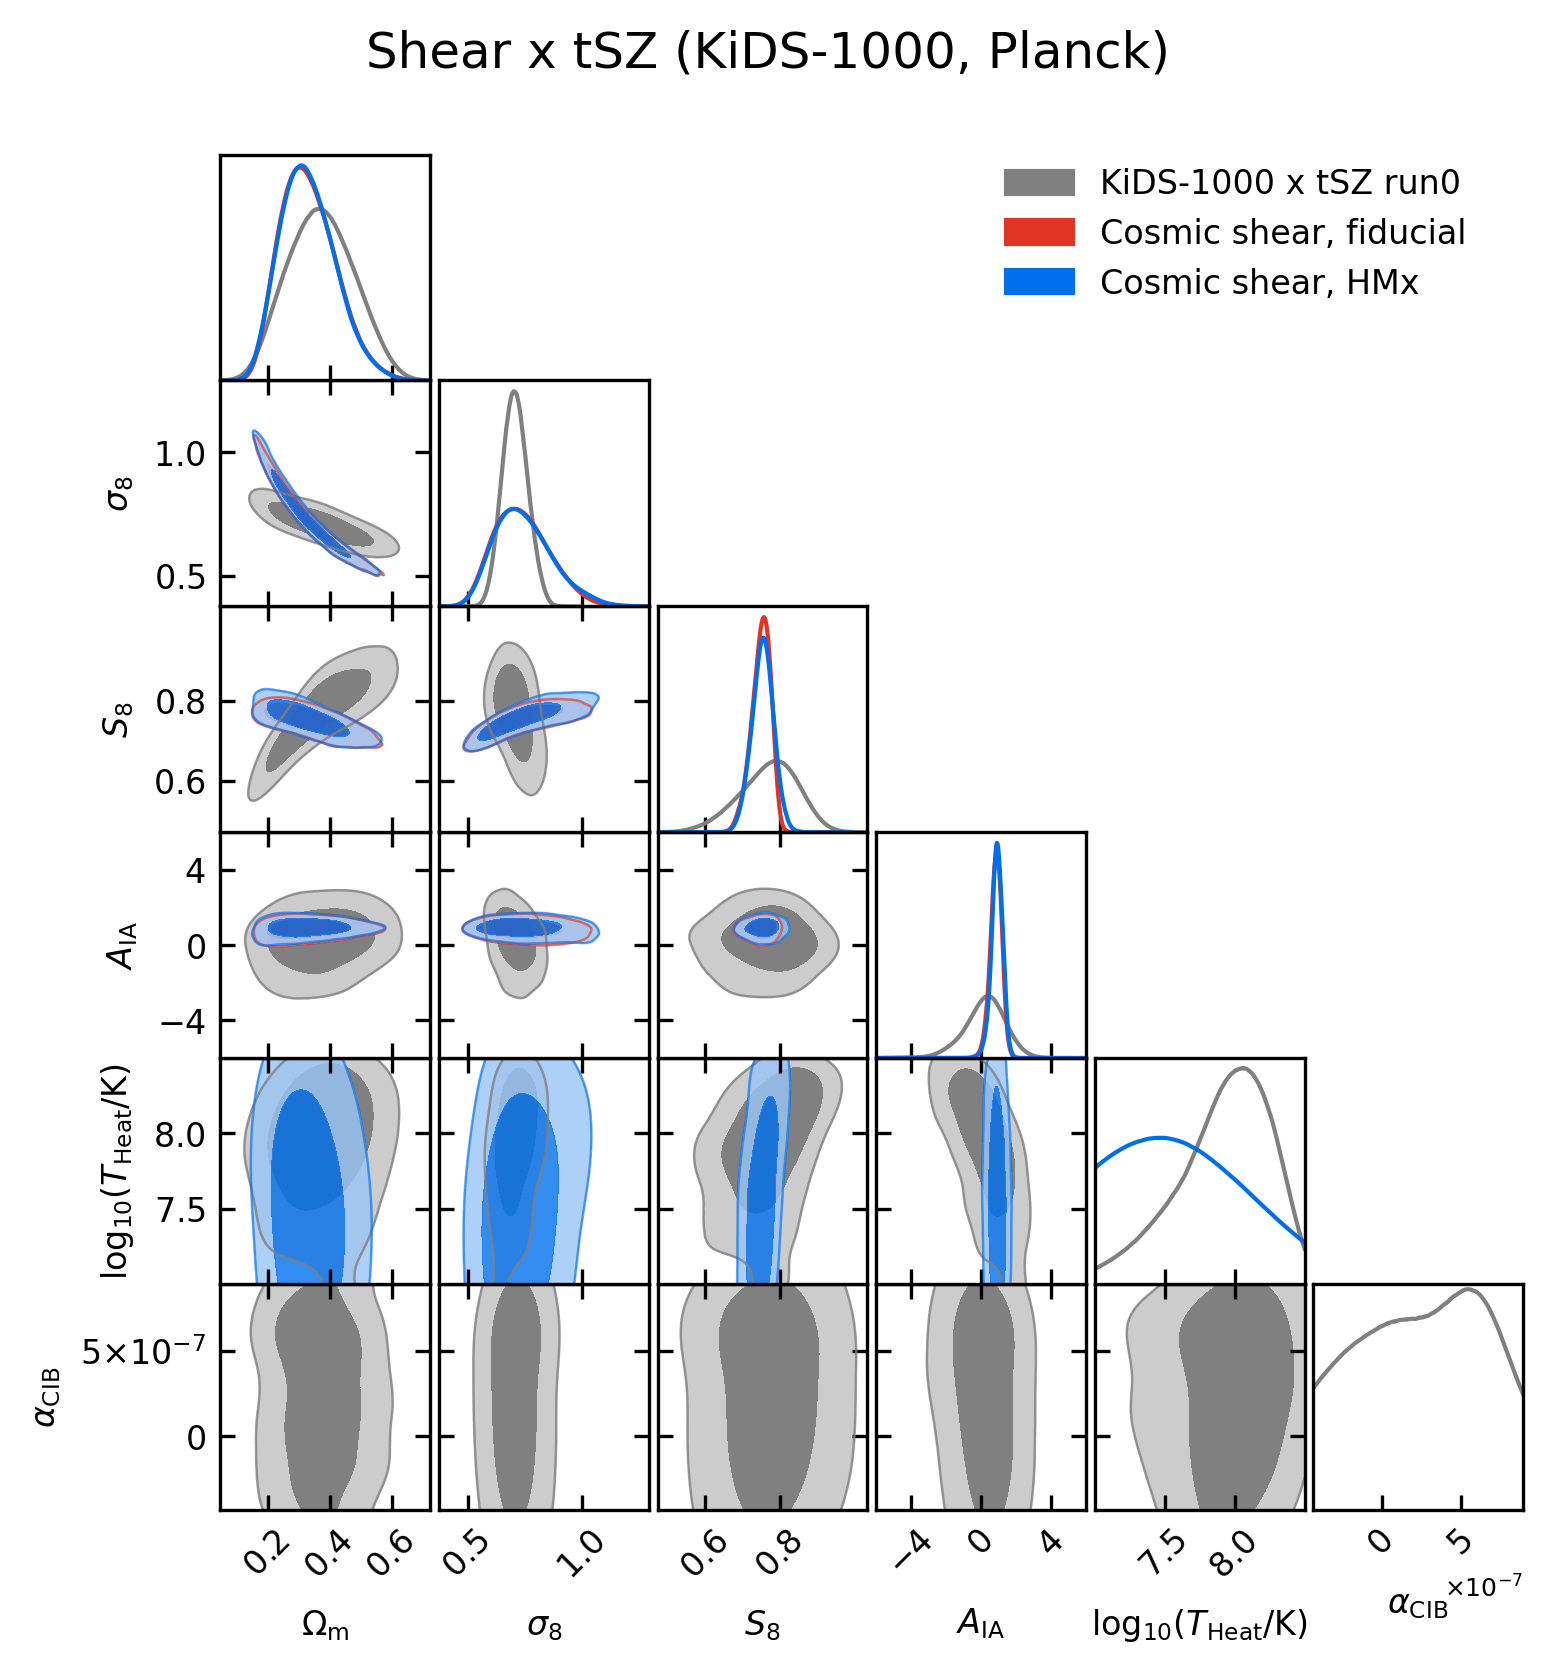

In [22]:
chain_selection = [{"name" : "run0",},
                   {"name" : "EE",},
                   {"name" : "EE_HMx",},
                  ]

chains_to_plot = select_chains(chains, chain_selection)

chain_colors = [get_chain_color(c) for c in chains_to_plot]
chain_labels = [get_chain_label(c) for c in chains_to_plot]

print(f"Plotting {len(chains_to_plot)} chains ({', '.join(chain_labels)})")

params_to_plot = ["omegam", "sigma8", "s8", "a_ia", "logt_heat", "alpha_cib"]

print(f"Plotting parameters {' '.join(params_to_plot)}")

width = 1.5*column_width
g = getdist.plots.get_subplot_plotter(width_inch=width, scaling=False,
                                      settings=copy.deepcopy(plot_settings))

g.settings.legend_fontsize = 8
g.settings.lab_fontsize = 8
g.settings.axes_fontsize = 8

g.triangle_plot(chains_to_plot,
                params=params_to_plot,
                filled_compare=True,
                #contour_colors=chain_colors,
                legend_labels=chain_labels,
                diag1d_kwargs={"normalized" : True},
               )

g.fig.suptitle("Shear x tSZ (KiDS-1000, Planck)", y=1.05)
g.fig.dpi = 300
bbox = matplotlib.transforms.Bbox(((0, 0), (width, 1.1*width)))
g.fig.savefig(f"plots/run0.png", bbox_inches=bbox)
